In [1]:
import os
import glob
import copy
import requests

import numpy as np

import astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.table import Table
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D

import matplotlib.pyplot as plt
from plot_utils import plot_cutouts, plot_img

# Read data and the images

All 33k objects across the pointing in all timestamps from all filters is already pre-prepared in this repo.

In [2]:
objects = Table.read("known_objects_in_cosmos_1_calibrated_exps.ecsv")

But the only, interesting, for us, object is the only KBO in the field:

In [3]:
obj_mask = objects["Name"] == "2008 AQ118"
filter_mask = objects["filter"] == "i DECam SDSS c0003 7835.0 1470.0"
mask = obj_mask & filter_mask

obj = objects[mask]
obj

<Table length=22>
Number    Name            RA                DEC                Type        ...   epoch                 fname                          obstime                        filter             
                         deg                deg                            ...     d                                                                                                    
int64    str15         float64            float64             str18        ...  float64                str34                           str27                         str32              
------ ---------- ------------------ ------------------ ------------------ ... --------- ---------------------------------- --------------------------- --------------------------------
    -- 2008 AQ118 149.87664583333333  4.005224166666666 KBO>Classical>Main ... 2459580.0 c4d_220103_065439_ooi_i_v1.fits.fz 2022-01-03T06:55:44.180096Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118  149.8764658333333  4.005232777777778 KBO>Classical>Main ... 2459580.0 c4d_220103_071244_ooi_i_v1.fits.fz 2022-01-03T07:13:49.340392Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118 149.87628624999996  4.005241666666667 KBO>Classical>Main ... 2459580.0 c4d_220103_073046_ooi_i_v1.fits.fz 2022-01-03T07:31:51.855479Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118 149.83219416666665  4.008018611111111 KBO>Classical>Main ... 2459580.0 c4d_220106_070127_ooi_i_v1.fits.fz 2022-01-06T07:02:32.305203Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118  149.8320020833333  4.008033055555556 KBO>Classical>Main ... 2459580.0 c4d_220106_071937_ooi_i_v1.fits.fz 2022-01-06T07:20:42.992937Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118  149.8318095833333  4.008047777777778 KBO>Classical>Main ... 2459580.0 c4d_220106_073746_ooi_i_v1.fits.fz 2022-01-06T07:38:51.665680Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118 149.78511708333332  4.012200277777778 KBO>Classical>Main ... 2459580.0 c4d_220109_070213_ooi_i_v1.fits.fz 2022-01-09T07:03:18.012652Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118  149.7849120833333  4.012221111111111 KBO>Classical>Main ... 2459580.0 c4d_220109_072031_ooi_i_v1.fits.fz 2022-01-09T07:21:36.976718Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118  149.7847083333333  4.012241388888889 KBO>Classical>Main ... 2459580.0 c4d_220109_073842_ooi_i_v1.fits.fz 2022-01-09T07:39:47.616218Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118 149.71850833333332  4.019863888888889 KBO>Classical>Main ... 2459590.0 c4d_220113_065922_ooi_i_v1.fits.fz 2022-01-13T07:00:27.083087Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118       149.71829125  4.019891944444445 KBO>Classical>Main ... 2459590.0 c4d_220113_071733_ooi_i_v1.fits.fz 2022-01-13T07:18:38.221076Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118         149.718075  4.019919722222222 KBO>Classical>Main ... 2459590.0 c4d_220113_073541_ooi_i_v1.fits.fz 2022-01-13T07:36:46.316664Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118       149.66576625  4.027138333333333 KBO>Classical>Main ... 2459590.0 c4d_220116_070506_ooi_i_v1.fits.fz 2022-01-16T07:06:11.438496Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118 149.66553958333333  4.027171666666667 KBO>Classical>Main ... 2459590.0 c4d_220116_072319_ooi_i_v1.fits.fz 2022-01-16T07:24:24.251378Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118       149.62950375  4.032671944444444 KBO>Classical>Main ... 2459590.0 c4d_220118_070205_ooi_i_v1.fits.fz 2022-01-18T07:03:10.265521Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118 149.62927291666665  4.032708333333333 KBO>Classical>Main ... 2459590.0 c4d_220118_072011_ooi_i_v1.fits.fz 2022-01-18T07:21:16.764845Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118 149.62904208333333           4.032745 KBO>Classical>Main ... 2459590.0 c4d_220118_073817_ooi_i_v1.fits.fz 2022-01-18T07:39:22.696418Z i DECam SDSS c0003 7835.0 1470.0
    -- 2008 AQ118 149.53462624999997 4.0489202777777775 KBO>Classical>Main ... 2459600.0 c4d_2201

The images can be downloaded from the known objects from NOIRLab's ADA:

In [4]:
def download_images(objs, root):
    collated_res = None
    ntot = len(objs)

    # Sort out the download into directory tree:
    # <root>
    #     - [i/g/r/u/z]
    filters = set(objs["filter"])
    for f in filters:
        os.makedirs(os.path.join(root, f[0]), exist_ok=True)

    for i, row in enumerate(objs):
        fname = row["fname"]
        

        print(f"[{i:>3}/{ntot:>3}] Downloading {fname:<35}", end="    ")
        try:
            response = requests.post("https://astroarchive.noirlab.edu/api/retrieve_by_name/" + fname)
            with open(os.path.join(root, row["filter"][0], row["fname"]), "wb") as f:
                      f.write(response.content)
        except:
            print("FAILED!")
            raise
        else:
            print("Done.")
            
    print("SUCCESS!")

    
root = "downloaded_images"
#download_images(obj, root)
imgs = {f.split("/")[-1]: fits.open(f) for f in glob.glob(f"{root}/i/*fits.fz")}

# Get WCSs, BBOXes and per-obj-row-hdu's

In [5]:
wcss, bboxes = [], []
for fn, hdul in imgs.items():
    for i, hdu in enumerate(hdul):
        wcs = WCS(hdu.header)
        bbox = wcs.calc_footprint()
        if bbox is not None:
            bboxes.append((i, bbox))
            wcss.append((i, wcs))
    break

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
 [astropy.wcs.wcs]


In [6]:
row_hdu_map = {}
cutoutsize = 100
cutouts = []
for i, row in enumerate(obj):
    img = imgs[row["fname"]]
    ephem = SkyCoord(row["RA"]*u.deg, row["DEC"]*u.deg)
    
    for j, wcs in wcss:
        if wcs.footprint_contains(ephem):
            hdu = img[j]
            row_hdu_map[i] = hdu
            cutouts.append(Cutout2D(hdu.data, ephem, cutoutsize, wcs=wcs))

# Plot the cutouts 

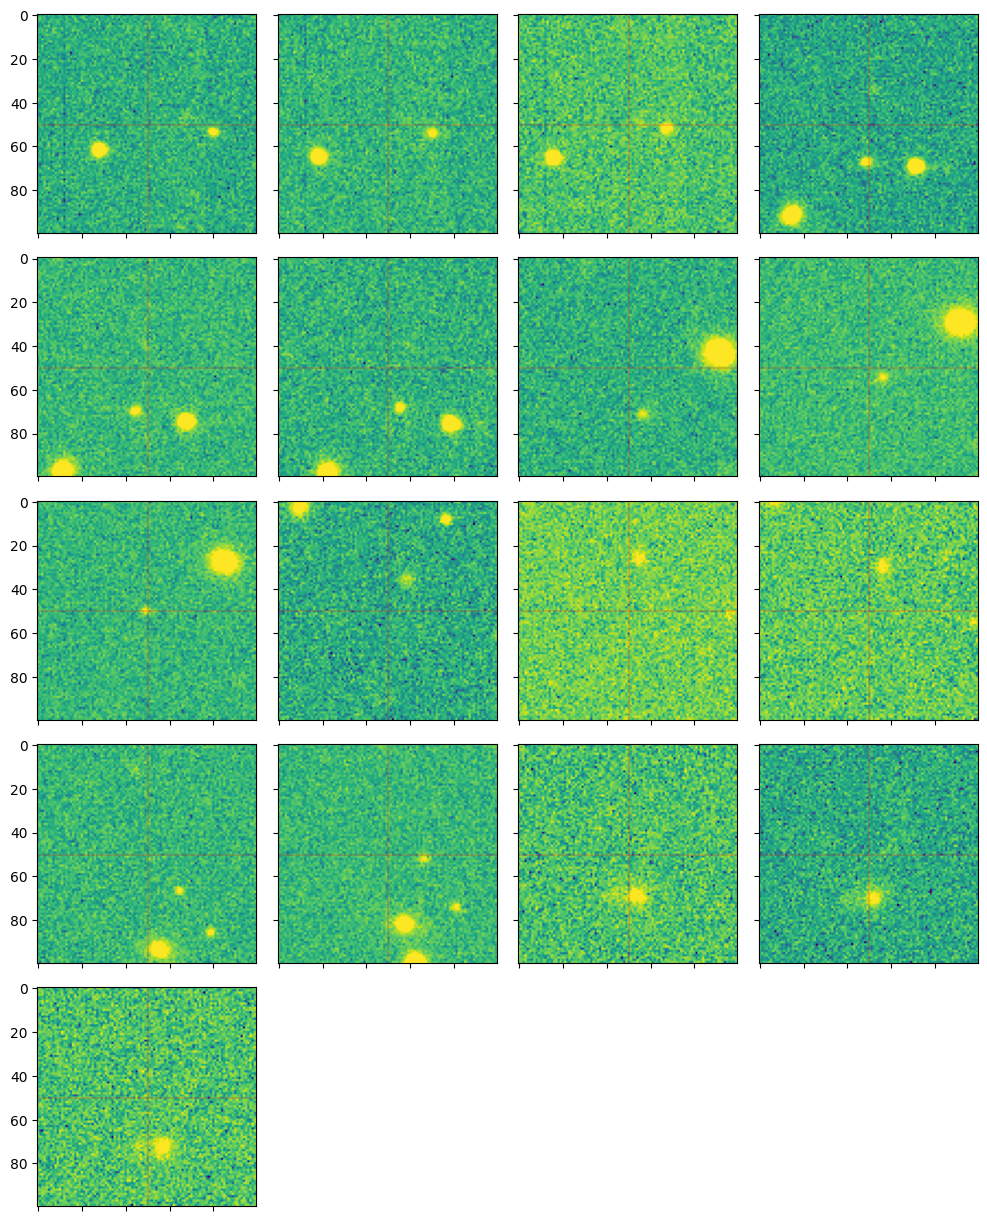

In [7]:
fig, axes = plt.subplots(ncols=4, nrows=9, figsize=(10, 22), sharex=True, sharey=True)
plot_cutouts(axes, cutouts)
fig.tight_layout()

In [8]:
# Stack the images into a single array with shape (cutout_dimx, cutout_dimy, N_cutouts)
# this helps with numpy vectorizations
cutout_imgs = [c.data for c in cutouts]
stack = np.dstack([c.data for c in cutouts])

## Mask and plot masked cutouts

And also stack them like before so that we can use numpy's vectorization to accelerate statistics calculations.

In [9]:
tmp = copy.deepcopy(cutout_imgs)

sg = SigmaClip(sigma=5, maxiters=10)
mskd_cutouts = []
for c in tmp:
    mskdarr = sg(c)
    c[mskdarr.mask] = 0
    mskd_cutouts.append(c)
    
mskd_stack = np.dstack([c for c in mskd_cutouts])

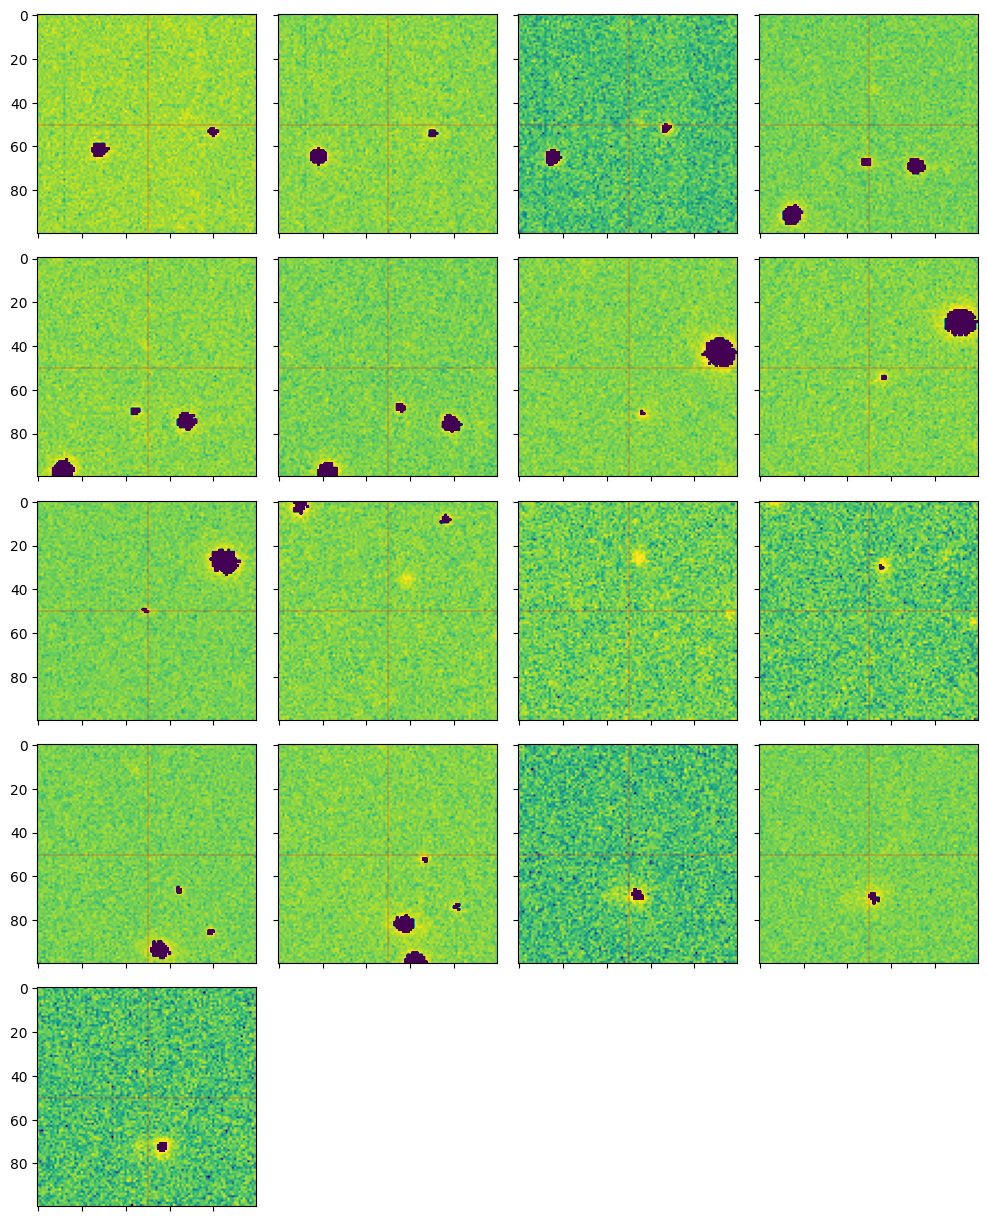

In [10]:
fig, axes = plt.subplots(ncols=4, nrows=9, figsize=(10, 22), sharex=True, sharey=True)
plot_cutouts(axes, mskd_cutouts)
fig.tight_layout()

# Summing cutouts

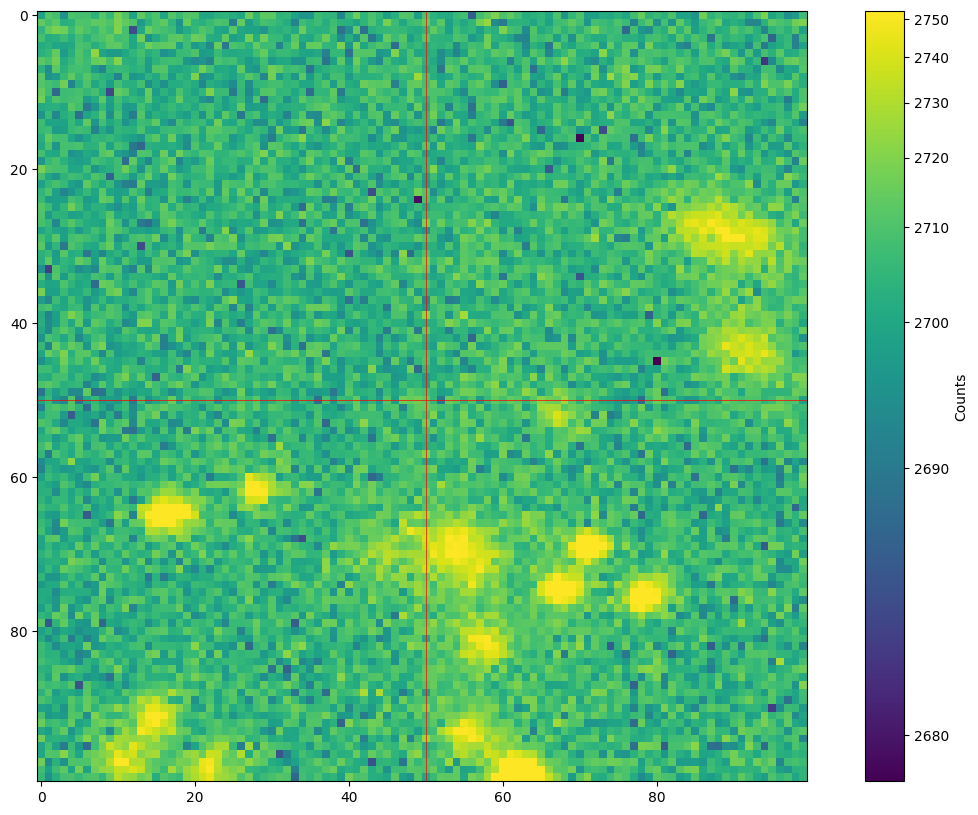

In [11]:
img = stack.mean(axis=2)
_, _ = plot_img(img)

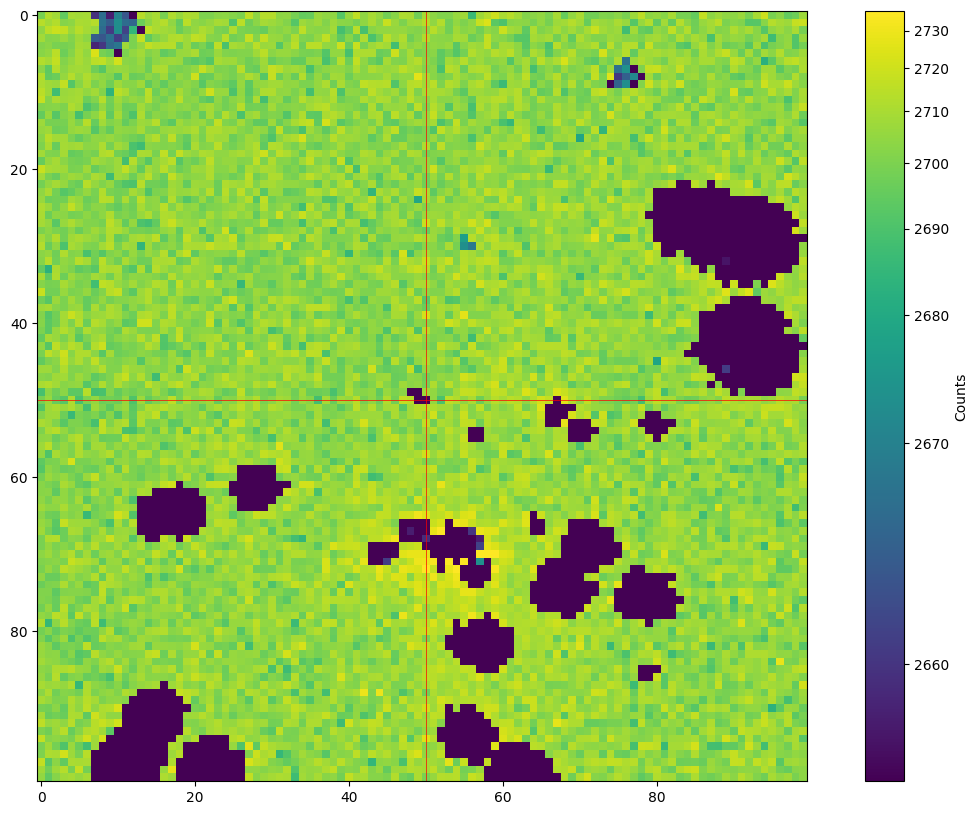

In [12]:
img = mskd_stack.mean(axis=2)
fig, ax = plot_img(img)

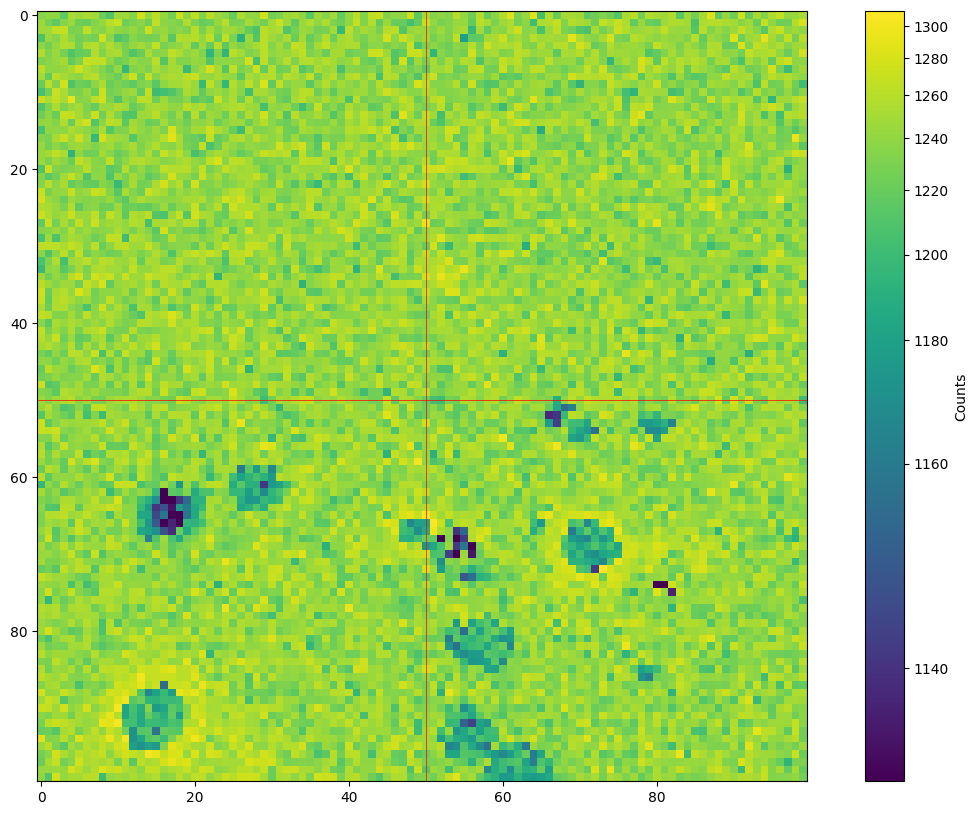

In [13]:
img = np.median(mskd_stack, axis=2)
fig, ax = plot_img(img)